# NAICS TIMESERIES ANALYSIS


The North American Industry Classification System (NAICS) is an industry classification system developed by 
the statistical agencies of Canada, Mexico and the United States. Created against the background of the 
North American Free Trade Agreement, it is designed to provide common definitions of the industrial structure of the 
three countries and a common statistical framework to facilitate the analysis of the three economies

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### load datasets

In [2]:
file_path=r'C:\Users\ssoziu\Desktop\Data Insights\NAICS time series analysis\A_NEWLY_HIRED_DATA_ANALYST'
level_2=['RTRA_Employ_2NAICS_00_05.csv','RTRA_Employ_2NAICS_06_10.csv','RTRA_Employ_2NAICS_11_15.csv','RTRA_Employ_2NAICS_16_20.csv','RTRA_Employ_2NAICS_97_99.csv']
level_3=['RTRA_Employ_3NAICS_00_05.csv','RTRA_Employ_3NAICS_06_10.csv','RTRA_Employ_3NAICS_11_15.csv','RTRA_Employ_3NAICS_16_20.csv','RTRA_Employ_3NAICS_97_99.csv']
level_4=['RTRA_Employ_4NAICS_00_05.csv','RTRA_Employ_4NAICS_06_10.csv','RTRA_Employ_4NAICS_11_15.csv','RTRA_Employ_4NAICS_16_20.csv','RTRA_Employ_4NAICS_97_99.csv']


### Preprocess data into consumable format

In [3]:
data_level2=pd.DataFrame()
for data in level_2:
    df= pd.read_csv(os.path.join(file_path,str(data)))
    df[['NAICS','CODE']] = df.NAICS.str.split("[",expand=True)
    df['CODE']=df['CODE'].replace({']':''}, regex=True)
    df[['CODE','UPPER_CODE']] = df.CODE.str.split("-",expand=True)
    data_level2 = data_level2.append(df, ignore_index=True)

data_level3=pd.DataFrame()
for data in level_3:
    df= pd.read_csv(os.path.join(file_path,str(data)))
    df[['NAICS','CODE']] = df.NAICS.str.split("[",expand=True)
    df['CODE']=df['CODE'].replace({']':''}, regex=True)
    df['UPPER_CODE'] = 0
    data_level3 = data_level3.append(df, ignore_index=True)
    
data_level4=pd.DataFrame()
for data in level_4:
    df= pd.read_csv(os.path.join(file_path,str(data)))
    df['CODE']=df['NAICS']
    df['UPPER_CODE'] = 0
    data_level4 = data_level4.append(df, ignore_index=True)
    
del df

### Getting the Combined data

In [4]:
data_combined=pd.DataFrame()

df=pd.DataFrame()
df=df.append(data_level2, ignore_index=True)
df=df.append(data_level3, ignore_index=True)
df=df.append(data_level4, ignore_index=True)

data_combined=data_combined.append(df, ignore_index=True)

del df

### Working with  the LMO names dataset

In [5]:
data_desc= pd.read_excel(os.path.join(file_path,'LMO_Detailed_Industries_by_NAICS.xlsx'))
data_desc['NAICS']=data_desc['NAICS'].replace({'&':','}, regex=True)
data_desc=data_desc[['NAICS','LMO_Detailed_Industry']]

data_desc1=data_desc[~data_desc['NAICS'].str.contains(',', na=False)]
data_desc2=data_desc[data_desc['NAICS'].str.contains(',', na=False)]


data_desc2=data_desc2.assign(NAICS=data_desc2['NAICS'].str.split(',')).explode('NAICS')


data_desc=data_desc1.append(data_desc2, ignore_index=True)
data_desc.columns=['CODE','LMO_Detailed_Industry']

### Joining codes to the output template

In [6]:
#load data
data_output= pd.read_excel(os.path.join(file_path,'Data_Output_Template.xlsx'))

#join tables
data_output=data_output.merge(data_desc,how='left', on='LMO_Detailed_Industry')

### Add data to the template

In [7]:
cols = ['SYEAR', 'SMTH', 'CODE']
data_output['check']= data_output[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_combined['check']= data_combined[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

data_combined=data_combined[['check', '_EMPLOYMENT_']]

In [8]:
data_output=data_output.merge(data_combined,how='left', on='check')

In [9]:
data_output.drop(['Employment','check'],axis=1,inplace=True)
data_output.columns=['SYEAR', 'SMTH', 'LMO_Detailed_Industry', 'CODE', 'Employment']

## Exploratory Analysis

### Sort the data set on year and month

In [10]:
data_output.sort_values(['SYEAR', 'SMTH'],inplace=True)

### How employment in Construction evolved overtime? 

In [11]:
#Picking off Construction data
construction=pd.DataFrame(data_output[data_output['CODE']==23].groupby(['SYEAR'])["Employment"].last()).reset_index()

Text(0.5, 1.0, 'Trend of Employment Numbers for the Construction sector')

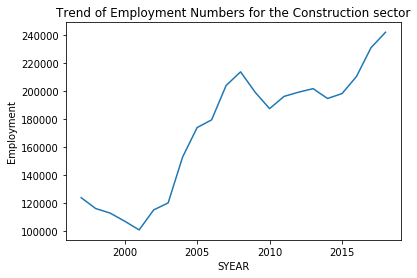

In [12]:
#Drawing a line plot to look at the evolutio over time
sns.lineplot(x='SYEAR',y='Employment',data=construction)
plt.title('Trend of Employment Numbers for the Construction sector')

We notice a couple of changes in employment numbers over the period.
A reduction in the numbers of workers in the construction sector was evident at the end of the 20th Century, it has been growing exponentially over the years with a spike during the 2008 recession period.
We also note that in the last decade the construction sector surffered a slight deep from around 2009 to 2015 and has been growing since to record growths of over 100%.

### Employment in Construction vs the total employment across all industries

In [13]:
#Picking off total yearly data
total=pd.DataFrame(data_output.groupby(['SYEAR','CODE'])["Employment"].last()).reset_index()

total=pd.DataFrame(total.groupby(['SYEAR'])["Employment"].sum()).reset_index()

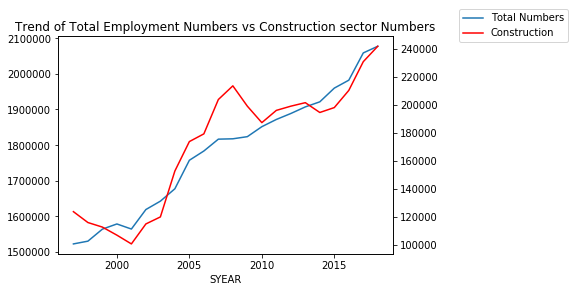

In [14]:
ax = total.plot(x='SYEAR',y='Employment', legend=False,label='Total Numbers')
ax2 = ax.twinx()
construction.plot(x='SYEAR',y='Employment', ax=ax2, legend=False,label='Construction', color="r")
plt.title('Trend of Total Employment Numbers vs Construction sector Numbers')
ax.figure.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


We see that at the end of the 20th century as construction jobs where steadily reducing the general market was enjoying an increase in the number of jobs. This can be attributed to the internet boom during those days.However the construction sector recovered in the mid 2000's with a spike in 2008 compared to a slow down in total employee numbers during the same period.
In the last 5 years however the construction sector has been growing at a slower rate compared to the general employment sector.

### What are the top 5 sectors with most employee numbers currently and investigate their evolution

In [15]:
#sort the data by year
data_level2=data_level2.sort_values(['SYEAR','SMTH'],ascending=True)

#Picking off total yearly data
_2018=pd.DataFrame(data_level2[data_level2['SYEAR']==2018].groupby(['CODE','NAICS'])["_EMPLOYMENT_"].last()).reset_index().sort_values(by='_EMPLOYMENT_',ascending=False)

C:\Users\ssoziu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:572: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_EMPLOYMENT_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0.5, 1.0, 'Employment Numbers for the Top 5 sectors')

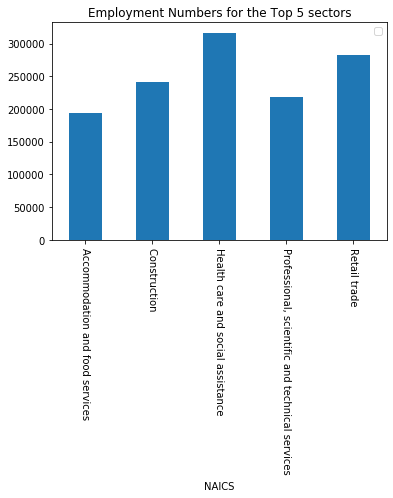

In [16]:
#pick off the top 5 sectors
top_5= _2018.head(5).sort_values(by='NAICS')

#Plot the top 5
ax=top_5.plot.bar(x='NAICS', y='_EMPLOYMENT_', rot=0)
plt.xticks(rotation =270)
plt.title('Employment Numbers for the Top 5 sectors')

Text(0.5, 1.0, 'Trend of Employment Numbers for the Top 5 sectors')

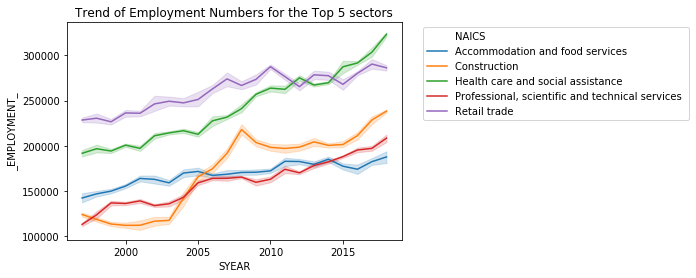

In [17]:
top_5_list=['72','23','62','54','44']

#looking at the evolution of these sectors
###Picking off the data
top_5_data=data_level2[data_level2['CODE'].isin(top_5_list)]

top_5_data=top_5_data[top_5_data['SYEAR']!=2019]

#Drawing a line plot to look at the evolutio over time
sns.lineplot(x='SYEAR',y='_EMPLOYMENT_',data=top_5_data,hue='NAICS',legend='brief')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Trend of Employment Numbers for the Top 5 sectors')

The construction sector has the most noticeable bump in growth since the early 2000's to date.
In the last decade however we have noticed that the  Health care sector overtook the Retail sector to become the top sector
,the construction and Proffesional sectors also have a noticeable growth over the decade.

### What are the 5 sectors with lowest numbers of Employess currently and investigate their evolution

C:\Users\ssoziu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:572: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_EMPLOYMENT_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0.5, 1.0, 'Employment Numbers for the bottom 5 sectors')

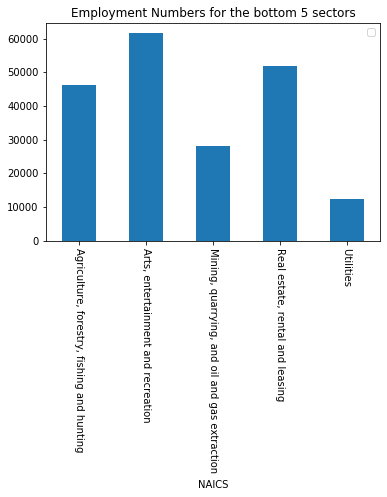

In [18]:
#pick off the bottom 5 sectors
tail_5= _2018.tail(5).sort_values(by='NAICS')
#Plot the bottom 5
ax=tail_5.plot.bar(x='NAICS', y='_EMPLOYMENT_', rot=0)
plt.xticks(rotation =270)
plt.title('Employment Numbers for the bottom 5 sectors')

Text(0.5, 1.0, 'Trend of Employment Numbers for the Bottom 5 sectors')

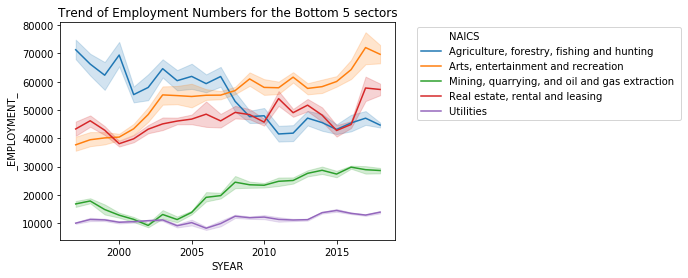

In [19]:
tail_5_list=['71','53','11','21','22']

#looking at the evolution of these sectors
###Picking off the data
tail_5_data=data_level2[data_level2['CODE'].isin(tail_5_list)]

tail_5_data=tail_5_data[tail_5_data['SYEAR']!=2019]

#Drawing a line plot to look at the evolutio over time
sns.lineplot(x='SYEAR',y='_EMPLOYMENT_',data=tail_5_data,hue='NAICS',legend='brief')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Trend of Employment Numbers for the Bottom 5 sectors')

There is a steep decline in opportunities in the Agricultural sector, with a steep drop around 2007 and stablizing in the last decade.
Also important to note that the Arts & entertainment and Mining sectora has been growing steadily overtime where as the Realestate and Utilities sectors have been rather stagnant with no major shifts over time.

### Which sectors are showing the higghest growth in employees over the last decade

In [20]:
#Picking off total yearly data
_1999=pd.DataFrame(data_level2[data_level2['SYEAR']==1999].groupby(['CODE','NAICS'])["_EMPLOYMENT_"].last()).reset_index().sort_values(by='_EMPLOYMENT_',ascending=False)
_1999=_1999[['CODE','_EMPLOYMENT_']]

_1999.columns=['CODE','Employment_1999']
_2018.columns=['CODE','NAICS','Employment_2018']

growth= _2018.merge(_1999, how='left',on='CODE')
growth['growth']=[(((y-x)*100)/x) for (x,y) in zip(growth['Employment_1999'],growth['Employment_2018'])]


Text(0.5, 1.0, 'Growth of various sectors over time')

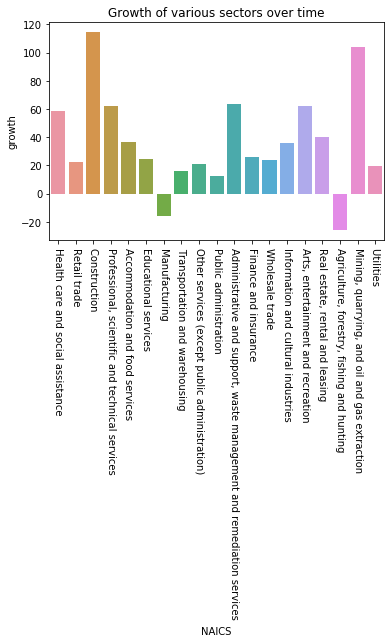

In [21]:
# draw the growth plots
sns.barplot(x='NAICS', y='growth',data=growth)
plt.xticks(rotation =270)
plt.title('Growth of various sectors over time')

We See majors enormous growth in the Construction,Mining with over 100% growth over time, the Admin,proffesional services and Healthcare sectors have over 50% growth with noteable reductions in the agricultural and Manufacturing sectors.
Generally most of the sectors have a somewhat positive growth over time, which is very impressive comparing the over time growth in population.

## Thank you